In [310]:
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, radius_graph, knn_graph
from torch_geometric.utils import remove_self_loops
from torch_scatter.scatter import scatter
from torch_scatter import scatter_min, scatter_max
from torch_cluster import knn
import matplotlib.pyplot as plt
from torch_cluster import fps
import pandas as pd
from gpgin import ConvLayer, MLP

from torch_geometric.typing import (
    Adj,
    OptTensor,
    SparseTensor,
    pyg_lib,
    torch_sparse,
)
from typing import Tuple, List, Dict, Union

In [2]:
def gridspace(start, end, n, dim):
    linspace = torch.linspace(start, end, steps=n)
    mesh = torch.meshgrid(*[linspace] * dim, indexing='ij')
    grid = torch.stack(mesh, dim=-1).reshape(-1, dim)
    return grid

In [3]:
def get_y(X):
    x=X[...,0]
    y=X[...,1]
    Y=torch.zeros_like(X)
    Y[...,0]=x.sin()-y.cos()
    Y[...,1]=y.sin()-x.cos()
    return Y

In [4]:
def plot_vector_field(X,Y,color=None,alpha=1.0):
    plt.quiver(
        X[:,0].detach().cpu(), 
        X[:,1].detach().cpu(), 
        Y[:,0].detach().cpu(), 
        Y[:,1].detach().cpu(), 
        color=color,
        alpha=alpha)

In [5]:
n_samples=200
x_dim=2
y_dim=2
X=gridspace(-3,3,int(n_samples**.5),2)
X=X+torch.randn_like(X)*0.05
tmp=(2*torch.pi*torch.arange(n_samples)/n_samples)
#X=torch.zeros(n_samples,x_dim)
#X[:,0]=tmp.sin()
#X[:,1]=tmp.cos()
Y=get_y(X)

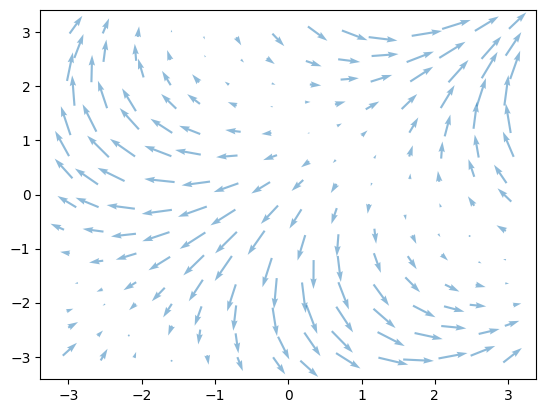

In [6]:
plot_vector_field(X,Y,alpha=0.5)

In [7]:
XT=torch.randn(n_samples,x_dim)*X.std()
YT=get_y(XT)

$$
\frac{x^{-2}}{\sum X^{-2}}
$$

$f(x,X,Y)=\sigma(\mathrm{aggregate}(\{\phi(x,\gamma(x-X_i),Y_i) \forall (X_i, Y_i) \in X \times Y\}))$

$f: \mathbb{R}^N \times \{\mathbb{R}^N\} \times \{\mathbb{R}^M\} \rightarrow \mathbb{R}^M$

In [9]:
class NoModel(MessagePassing):
    def __init__(self,k=8,p=1):
        super().__init__(aggr='sum')
        self.k=k
        self.p=p
        
    def forward(self, K, V, mask=None, batch=None):
        # K->V is the sampled vector field
        #K: torch.Size([100, 2]) -> positions
        #V: torch.Size([100, 2]) -> vectors in that position
        #w: torch.Size([3267, 1])
        if mask is None or mask.all():
            mask=torch.ones(K.shape[-2],dtype=torch.bool, device=K.device)
            edge_index = knn(K, K, self.k, batch_x=batch, batch_y=batch).flip(0)
        else:
            if batch is None:
                batch=torch.zeros(K.shape[-2],device=K.device)
            query_indices = mask.nonzero(as_tuple=True)[0].to(K.device)  # shape: [M]
            edge_index = knn(K[mask], K, self.k, batch_x=batch[mask], batch_y=batch).flip(0)
            edge_index[0] = query_indices[edge_index[0]]
        row,col=edge_index
        diffs = K[row]-K[col]
        dists = diffs.norm(2,-1)+1e-8
        idists = dists.pow(-self.p)
        sumidists = scatter(idists, col, dim=-1, reduce="sum")[col]
        w = (idists/sumidists).view(-1,1)
        out = self.propagate(
            edge_index, 
            v=V, 
            w=w,
        )
        return out, edge_index
        
    def message(self, v_j, w):
        return (v_j)*w

In [390]:
class Decoder(MessagePassing):
    def __init__(self,k_dim,v_dim,hidden_size=120,k=10,p=2):
        super().__init__(aggr='sum')
        self.k=k
        self.p=p
        self.psi=nn.Sequential(
            nn.Linear(k_dim,hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size,v_dim)
        )
        self.phi=nn.Sequential(
            nn.Linear(v_dim,hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size,v_dim)
        )
        
    def forward(self, K, V, Q, batch_kv=None, batch_q=None):
        #K          f32:  N, k_dim
        #V          f32:  N, v_dim
        #Q          f32:  M, v_dim
        #batch_kv usize:  N
        #batch_q  usize:  M
        if batch_kv is None:
            batch_kv=torch.zeros(K.shape[-2],device=K.device)
        if batch_q is None:
            batch_q=torch.zeros(Q.shape[-2],device=Q.device)
        src,tgt=edge_index = knn(K, Q, self.k, batch_x=batch_kv, batch_y=batch_q).flip(0)
        diffs = Q[tgt]-K[src]
        phi_out = self.psi(diffs)
        dists = diffs.norm(2,-1)+1e-8
        idists = dists.pow(-self.p)
        sumidists = scatter(idists, tgt, dim=-1, reduce="sum")[tgt]
        w = phi_out*(idists/sumidists).view(-1,1)
        v=self.phi(V)
        out = self.propagate(
            edge_index, 
            v=(v,Q), 
            w=w,
            sizes=(K.shape[-2],Q.shape[-2])
        )#out: ?
        return out
        
    def message(self, v_j, w):
        return v_j*w

In [392]:
d=Decoder(2,2)
d(X,X,X[:4]).shape,X.shape

(torch.Size([4, 2]), torch.Size([196, 2]))

In [351]:
class DownSampler(nn.Module):
    def __init__(self,
            ratio,
            mlp_dims_node: List[int],
            mlp_dims_edge: List[int],
            
            aggr: str = 'sum',
            
            node_norm=nn.LayerNorm, 
            final_node_norm=nn.Identity, 
            
            edge_norm=nn.LayerNorm,
            final_edge_norm=nn.Identity, 
            
            activation=nn.SiLU, 
            final_activation=nn.Identity, 
            
            dropout_rate=0.1, 
            final_dropout_rate=0.0,
            ):
        super().__init__()
        self.ratio=ratio
        self.conv = ConvLayer(
            mlp_dims_node=mlp_dims_node,
            mlp_dims_edge=mlp_dims_edge,
            aggr=aggr,
            node_norm=node_norm,
            final_node_norm=final_node_norm,
            edge_norm=edge_norm,
            final_edge_norm=final_edge_norm,
            activation=activation,
            final_activation=final_activation,
            dropout_rate=dropout_rate,
            final_dropout_rate=final_dropout_rate,
        )
        self.reset_parameters()
        
    def reset_parameters(self):
        self.conv.reset_parameters()
        
    def forward(self, K, V, batch=None):
        #K float:     N, k_dim
        #V float:     N, v_dim
        #batch int: N
        if batch is None:
            batch=torch.zeros(K.shape[-2],device=K.device,dtype=torch.long)
        sampled_idx = fps(
            K, 
            ratio=self.ratio, 
            batch=batch, 
            random_start=True
        )
        edge_index = knn(
            K[sampled_idx], #src
            K, #tgt
            1, 
            batch_x=batch[sampled_idx], 
            batch_y=batch)
        src, tgt = edge_index
        dK = K[sampled_idx][tgt]-K[src]
        pooledV = self.conv(
            (V, torch.zeros_like(V[sampled_idx])), 
            edge_index, 
            dK)
        return K[sampled_idx], pooledV, batch[sampled_idx], edge_index

In [352]:
class UpSampler(nn.Module):
    def __init__(self,
            mlp_dims_node: List[int],
            mlp_dims_edge: List[int],
            
            aggr: str = 'sum',
            
            node_norm=nn.LayerNorm, 
            final_node_norm=nn.Identity, 
            
            edge_norm=nn.LayerNorm,
            final_edge_norm=nn.Identity, 
            
            activation=nn.SiLU, 
            final_activation=nn.Identity, 
            
            dropout_rate=0.1, 
            final_dropout_rate=0.0,
            ):
        super().__init__()
        self.conv = ConvLayer(
            mlp_dims_node=mlp_dims_node,
            mlp_dims_edge=mlp_dims_edge,
            aggr=aggr,
            node_norm=node_norm,
            final_node_norm=final_node_norm,
            edge_norm=edge_norm,
            final_edge_norm=final_edge_norm,
            activation=activation,
            final_activation=final_activation,
            dropout_rate=dropout_rate,
            final_dropout_rate=final_dropout_rate,
        )
        self.reset_parameters()
        
    def reset_parameters(self):
        self.conv.reset_parameters()
        
    def forward(self, K1, K2, V1, V2, edge_index):
        tgt, src = reversed_edge_index = edge_index.flip(0)
        dK = K2[tgt]-K1[src]
        informed_V1 = self.conv(
            (V2, V1), 
            reversed_edge_index, 
            dK)
        return informed_V1

In [408]:
class UNet(nn.Module):
    def __init__(self,
            ratios,
            mlp_dims_node: List[int],
            mlp_dims_edge: List[int],
            
            aggr: str = 'sum',
            
            node_norm=nn.LayerNorm, 
            final_node_norm=nn.Identity, 
            
            edge_norm=nn.LayerNorm,
            final_edge_norm=nn.Identity, 
            
            activation=nn.SiLU, 
            final_activation=nn.Identity, 
            
            dropout_rate=0.1, 
            final_dropout_rate=0.0,
            ):
        super().__init__()
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        self.n_layers = len(ratios)
        for ratio in ratios:
            down=DownSampler(
                ratio=ratio,
                mlp_dims_node=mlp_dims_node,
                mlp_dims_edge=mlp_dims_edge,
                aggr=aggr,
                node_norm=node_norm,
                final_node_norm=final_node_norm,
                edge_norm=edge_norm,
                final_edge_norm=final_edge_norm,
                activation=activation,
                final_activation=final_activation,
                dropout_rate=dropout_rate,
                final_dropout_rate=final_dropout_rate,
            )
            up=UpSampler(
                mlp_dims_node=mlp_dims_node,
                mlp_dims_edge=mlp_dims_edge,
                aggr=aggr,
                node_norm=node_norm,
                final_node_norm=final_node_norm,
                edge_norm=edge_norm,
                final_edge_norm=final_edge_norm,
                activation=activation,
                final_activation=final_activation,
                dropout_rate=dropout_rate,
                final_dropout_rate=final_dropout_rate,
            )
            self.downs.append(down)
            self.ups.append(up)
        self.reset_parameters()
        
    def reset_parameters(self):
        for d in self.downs:
            d.reset_parameters()
        for u in self.ups:
            u.reset_parameters()
        
    def forward(self, K, V, batch=None):
        res=[(K, V, batch, None)]
        for i,down in enumerate(self.downs):
            K, V, batch, edge_index = out = down(K, V, batch)
            if i+1<self.n_layers:
                res.append(out)
        for up, (_K, _V, _, _edge_index) in zip(self.ups, reversed(res)):
            V=up(_K, K, _V, V, edge_index)
            K=_K
            edge_index=_edge_index
        return V

In [412]:
class VFInterpolator(nn.Module):
    def __init__(self,
            domain_dim,
            raw_feature_dim,
            latent_feature_dim,
            ratios,
            mlp_dims_node: List[int],
            mlp_dims_edge: List[int],
            
            aggr: str = 'sum',
            
            node_norm=nn.LayerNorm, 
            final_node_norm=nn.Identity, 
            
            edge_norm=nn.LayerNorm,
            final_edge_norm=nn.Identity, 
            
            activation=nn.SiLU, 
            final_activation=nn.Identity, 
            
            dropout_rate=0.1, 
            final_dropout_rate=0.0,

            decoder_hidden_size=120,
            k=1,
            p=2,
            ):
        super().__init__()
        assert mlp_dims_node[0]==mlp_dims_node[-1]==mlp_dims_edge[-1]==latent_feature_dim
        self.proj_in =nn.Linear(raw_feature_dim,latent_feature_dim)
        self.proj_out=nn.Linear(latent_feature_dim,raw_feature_dim)
        self.encoder=UNet(
                ratios=ratios,
                mlp_dims_node=mlp_dims_node,
                mlp_dims_edge=mlp_dims_edge,
                aggr=aggr,
                node_norm=node_norm,
                final_node_norm=final_node_norm,
                edge_norm=edge_norm,
                final_edge_norm=final_edge_norm,
                activation=activation,
                final_activation=final_activation,
                dropout_rate=dropout_rate,
                final_dropout_rate=final_dropout_rate,)
        self.decoder=Decoder(domain_dim,latent_feature_dim,hidden_size=decoder_hidden_size,k=k,p=p)
    def forward(self, K, V, Q, batch_kv=None, batch_q=None):
        projected_V = self.proj_in(V)
        V_hidden = self.encoder(K,projected_V, batch_kv)
        out = self.decoder(K, V_hidden, Q, batch_kv, batch_q)
        pred = self.proj_out(out)
        return pred

In [416]:
pwd

'C:\\Users\\umarzein\\Desktop\\novel_research'

In [415]:
model(X,X,X).shape,X.shape

(torch.Size([196, 2]), torch.Size([196, 2]))

In [414]:
model=VFInterpolator(
    2,2,10,
    [.5,.5,.5],
    [10,20,10],
    [2,20,10],)

In [ ]:
unet=UNet(
    [0.5,0.5,0.5]
)

In [409]:
unet

UNet(
  (downs): ModuleList(
    (0-2): 3 x DownSampler(
      (conv): ConvLayer()
    )
  )
  (ups): ModuleList(
    (0-2): 3 x UpSampler(
      (conv): ConvLayer()
    )
  )
)

In [407]:
unet(X,X).shape,X.shape

(torch.Size([98, 2]), torch.Size([196, 2]))

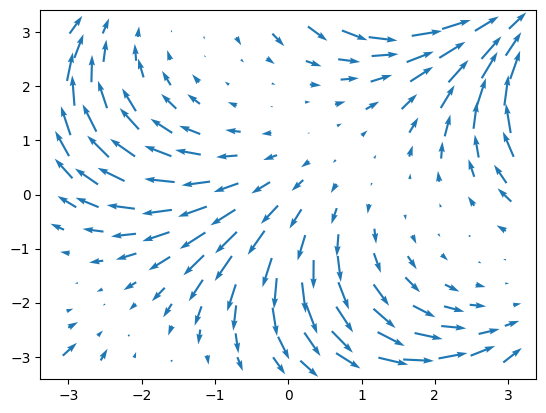

In [358]:
plot_vector_field(X,Y)

In [88]:
f=DownSampler(
    0.1,
    [2,2],
    [2,2],
)
g=UpSampler(
    [2,2],
    [2,2],
)

In [89]:
K2, V2, _, edge_index = f(X,X)
V3 = g(X, K2, X, V2, edge_index)

In [90]:
V2.shape,X.shape

(torch.Size([20, 2]), torch.Size([196, 2]))

In [176]:
from tqdm.auto import tqdm
model=Predictor().cuda()
X_=X.clone().cuda()
Y_=Y.clone().cuda()
XT_=XT.clone().cuda()
YT_=YT.clone().cuda()
optim=torch.optim.AdamW(model.parameters())
iterator=tqdm(range(10000))
for epoch in iterator:
    mask=torch.rand(X_.shape[-2],device=X_.device)<.2
    pred=model(X_,Y_,mask=mask)
    loss=(pred[~mask]-Y_[~mask]).pow(2).mean()
    with torch.no_grad():
        predT=model(XT_,YT_)
        eval_=(predT-YT_).pow(2).mean()
    model.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()
    iterator.set_description(f"{float(loss.log()):.3f}->{float(eval_.log()):.3f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

(torch.Size([100, 2]), torch.Size([100, 2]))

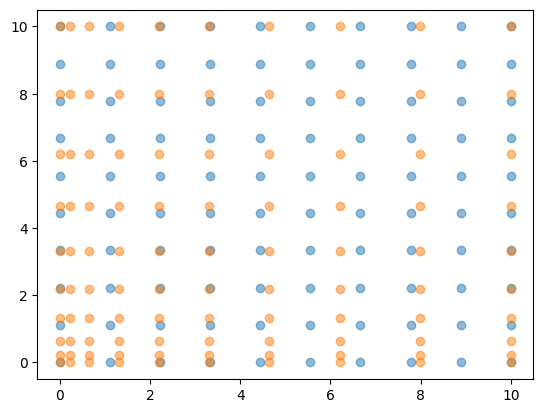

In [135]:
P1=gridspace(0,10,10,2)
P2=P1+(P1**2)
P2=P2/P2.max()*P1.max()
#P2=gridspace(0,10,20,2)
plt.scatter(*P1.T,alpha=0.5)
plt.scatter(*P2.T,alpha=0.5)
P1.shape,P2.shape

In [181]:
P1.shape

torch.Size([100, 2])

In [205]:
src = torch.tensor([1., 2., 3., 4., 5., 6.])
index = torch.tensor([0, 1, 0, 1, 2, 1])
input = torch.tensor([1., 2., 3., 4.])
input.scatter_reduce(0, index, src, reduce="sum")

tensor([ 5., 14.,  8.,  4.])

In [208]:
src = torch.tensor([1., 2., 3., 4., 5., 6.])
index = torch.tensor([0, 1, 0, 1, 2, 1])
input = torch.tensor([1., 2., 3., 4.])*0
input.scatter_reduce(0, index, src, reduce="sum")

tensor([ 4., 12.,  5.,  0.])

In [236]:
sampled_idx.shape

torch.Size([10])

In [235]:
torch.zeros(edge_index[1].max()+1,dtype=torch.float).shape

torch.Size([20])

In [272]:
tmp=torch.rand_like(edge_idx[0].float())
torch.zeros(
    sampled_idx.shape[0],
    dtype=torch.float
).scatter_reduce(
    0,
    edge_idx[0],
    tmp,
    reduce='amax'
)

tensor([0.8777, 0.4303, 0.8984, 0.9637, 0.8757, 0.9254, 0.9730, 0.5017, 0.7863,
        0.8902])

In [274]:
tmp.amax(),tmp.max()

(tensor(0.9730), tensor(0.9730))

In [275]:
help(tmp.amax)

Help on built-in function amax:

amax(...) method of torch.Tensor instance
    amax(dim=None, keepdim=False) -> Tensor
    
    See :func:`torch.amax`



In [295]:
torch.rand(P2.shape[0]).shape,edge_index.shape

(torch.Size([100]), torch.Size([2, 196]))

In [316]:
P2.shape,edge_index.shape,indices.shape

(torch.Size([100, 2]), torch.Size([2, 196]), torch.Size([20]))

In [322]:
indices

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [323]:
edge_idx[0]

tensor([0, 0, 0, 0, 0, 0, 6, 6, 3, 3, 0, 0, 0, 0, 0, 0, 6, 6, 3, 3, 0, 0, 0, 0,
        0, 0, 6, 6, 3, 3, 0, 0, 0, 0, 0, 9, 6, 6, 6, 3, 5, 5, 0, 0, 9, 9, 6, 6,
        6, 3, 5, 5, 5, 5, 9, 9, 9, 6, 6, 7, 5, 5, 5, 5, 9, 9, 4, 4, 7, 7, 5, 5,
        5, 5, 4, 4, 4, 4, 7, 7, 2, 2, 2, 2, 2, 4, 4, 4, 1, 1, 2, 2, 2, 2, 2, 8,
        8, 8, 1, 1])

In [292]:
P2.shape,P2[sampled_idx].shape

(torch.Size([100, 2]), torch.Size([10, 2]))

In [346]:
p2t

tensor([501.3860, 495.1505])

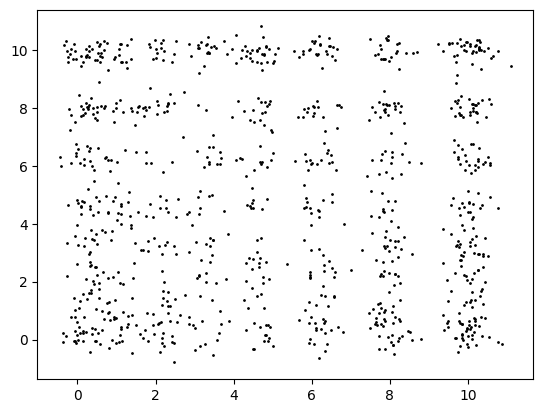

In [347]:

p2t=torch.tensor([0.0,0.0])
r=100
for _ in range(r):
    sampled_idx = fps(P2, batch=None, ratio=0.1, random_start=True)
    edge_idx=knn(P2[sampled_idx],P2,1).flip(0)
    _, indices = scatter_min(torch.rand(edge_idx.shape[1]), edge_idx[0], dim=0)
    p2t=p2t+P2[indices].mean(0)
    #plt.scatter(*P2[indices].T, alpha=min(1,1/r), s=1000,c='black')
    plt.scatter(*(P2[indices]+torch.randn_like(P2[indices])*0.3).T, s=1,c='black')
    # Plot nodes
    #plt.scatter(*P2.T, color='black', zorder=2,alpha=0.1)
    #plt.scatter(*P2[sampled_idx].T, color='red', zorder=2, alpha=2/r)

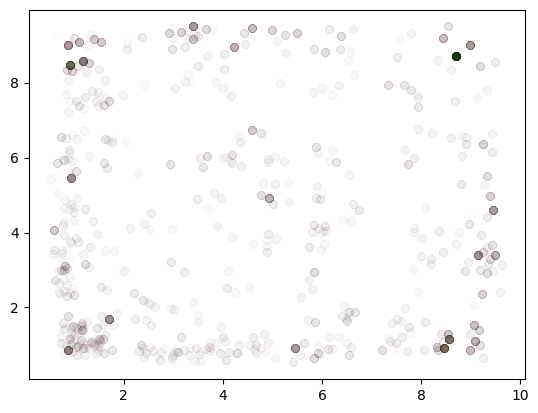

In [200]:
r=1000
for _ in range(r):
    sampled_idx = fps(P2, batch=None, ratio=0.1, random_start=True)
    edge_idx=knn(P2[sampled_idx],P2,2).flip(0)
    plt.scatter(*scatter(P2[edge_idx[1]], edge_idx[0], dim=0, reduce='mean').T, alpha=5/r)
    # Plot nodes
    #plt.scatter(*P2.T, color='black', zorder=2,alpha=0.1)
    #plt.scatter(*P2[sampled_idx].T, color='red', zorder=2, alpha=2/r)

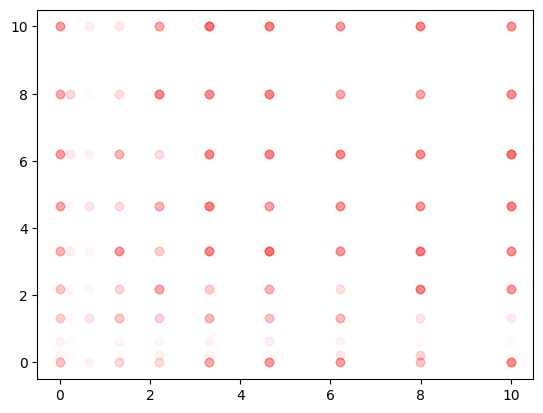

In [170]:
r=300
for _ in range(r):
    sampled_idx = fps(P2, batch=None, ratio=0.5, ptr=)
    sampled_idx = sampled_idx[torch.rand_like(sampled_idx.float())<(0.1/0.5)]
    # Plot nodes
    #plt.scatter(*P2.T, color='black', zorder=2)
    plt.scatter(*P2[sampled_idx].T, color='red', zorder=2, alpha=2/r)

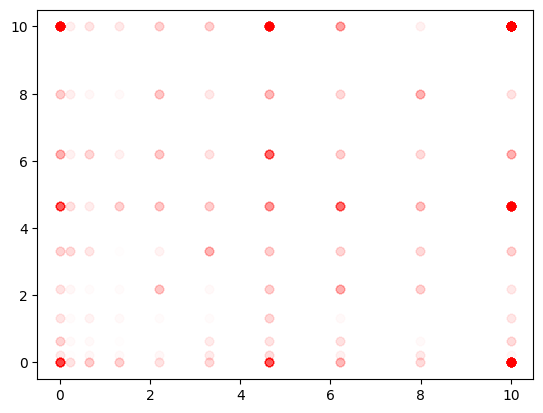

In [171]:
r=300
for _ in range(r):
    sampled_idx = fps(P2, batch=None, ratio=0.1, random_start=True)
    # Plot nodes
    #plt.scatter(*P2.T, color='black', zorder=2)
    plt.scatter(*P2[sampled_idx].T, color='red', zorder=2, alpha=2/r)

In [161]:
torch.rand_like(sampled_idx.float())

tensor([0.4662, 0.6022, 0.5103, 0.1317, 0.6526, 0.5232, 0.5672, 0.7559, 0.2700,
        0.1706, 0.2253, 0.5301, 0.5784, 0.2099, 0.2776, 0.8101, 0.1118, 0.0790,
        0.9185, 0.0750, 0.8268, 0.0413, 0.2222, 0.4136, 0.6927, 0.1705, 0.2916,
        0.3440, 0.9523, 0.9776, 0.6638, 0.1217, 0.1876, 0.1501, 0.8888, 0.7179,
        0.7014, 0.6280, 0.7082, 0.8266, 0.0478, 0.7393, 0.2596, 0.7093, 0.9652,
        0.1362, 0.9871, 0.3089, 0.9681, 0.3783])

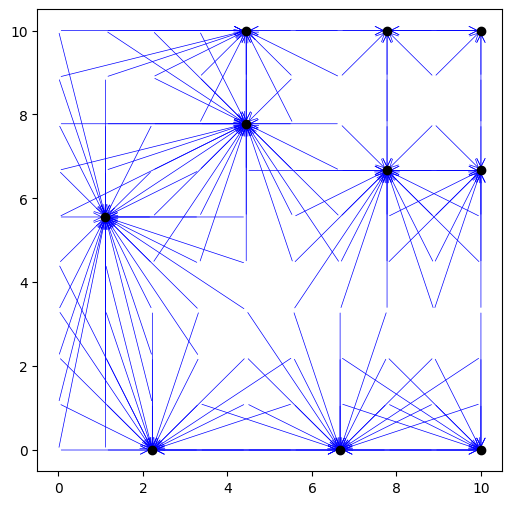

In [172]:

from matplotlib.patches import FancyArrowPatch

fig, ax = plt.subplots(figsize=(6, 6))

# Plot nodes
ax.scatter(*P1[sampled_idx].T, color='black', zorder=2)

# Draw arrows
for src, dst in knn(P1[sampled_idx],P1,2).cpu().T:
    start = P1[src]
    end = P1[sampled_idx][dst]
    arrow = FancyArrowPatch(
        posA=start,
        posB=end,
        arrowstyle='->',
        color='blue',
        mutation_scale=15,
        linewidth=0.5
    )
    ax.add_patch(arrow)
plt.savefig("tmp.svg")

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
         90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
        [ 7,  7,  7,  0,  0,  0,  0,  0,  6,  6,  7,  7,  7,  0,  0,  0,  0,  0,
          6,  6,  3,  3,  3,  8,  8,  8,  8,  4,  4,  6,  3,  3,  3,  8,  8,  8,
          8,  4,  4,  4,  3,  3,  9,  8,  8,  8,  4,  4,  4,  4,  9,  9,  9,  8,
          8,  8,  4,  4,  4,  4,  9,  9,  9,  5,  5,  5,  5,  4,  4,  4,  9,  9,
          9,  5,  5,  5,  5,  2,  2,  2,  1,  1,  1,  5,  5,  5,  5,  2,  2,  2,
          1,  1,  1,  5,  5,  5,  5,  2,  2,  2]])

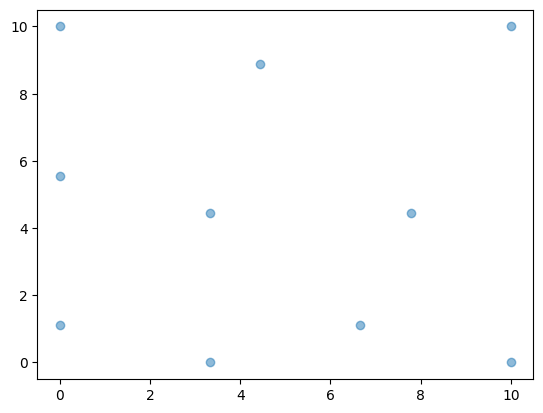

In [138]:
plt.scatter(*P1[sampled_idx].T,alpha=0.5)

In [381]:
((P1-P1[50]).norm(2,-1)+1).pow(-1).sum()

tensor(17.4751)

In [405]:
calculate_density(P1,p=2).mean()

tensor(5.4431)

In [406]:
calculate_density(P2,p=2).mean()

tensor(25.5045)

In [395]:
((P1-P1[50]).norm(2,-1)+1).pow(-2).sum()

tensor(4.4745)

In [378]:
r_k=(P1-P1[50]).norm(2,-1).topk(10,0,largest=False).values[-1]
1/r_k**2

tensor(0.1620)

In [377]:
r_k=(P2-P2[200]).norm(2,-1).topk(10,0,largest=False).values[-1]
1/r_k**2

tensor(0.7220)

In [574]:
help(fps)

Help on function fps in module torch_cluster.fps:

fps(src: torch.Tensor, batch: Optional[torch.Tensor] = None, ratio: Union[torch.Tensor, float, NoneType] = None, random_start: bool = True, batch_size: Optional[int] = None, ptr: Union[torch.Tensor, List[int], NoneType] = None)
    "A sampling algorithm from the `"PointNet++: Deep Hierarchical Feature
    Learning on Point Sets in a Metric Space"
    <https://arxiv.org/abs/1706.02413>`_ paper, which iteratively samples the
    most distant point with regard to the rest points.
    
    Args:
        src (Tensor): Point feature matrix
            :math:`\mathbf{X} \in \mathbb{R}^{N \times F}`.
        batch (LongTensor, optional): Batch vector
            :math:`\mathbf{b} \in {\{ 0, \ldots, B-1\}}^N`, which assigns each
            node to a specific example. (default: :obj:`None`)
        ratio (float or Tensor, optional): Sampling ratio.
            (default: :obj:`0.5`)
        random_start (bool, optional): If set to :obj:`False`, 

$\frac{\mathrm{1 point}}{\mathrm{1m}^2}$

In [360]:
def calculate_density_kernel(pos, batch=None, k=15, sigma=1.0):
    # Get neighbors: edge_index shape [2, num_edges]
    edge_index = knn(pos, pos, k, batch_x=batch, batch_y=batch).flip(0)
    #edge_index, _ = remove_self_loops(edge_index)
    src, tgt = edge_index

    diffs = pos[src] - pos[tgt]
    dists_sq = (diffs ** 2).sum(dim=-1)  # squared Euclidean distance

    # Gaussian kernel weights (unnormalized)
    weights = torch.exp(-dists_sq / (2 * sigma ** 2)) + 1e-9  # add epsilon for stability

    # Normalize weights per source node so weights sum to 1 (mass-preserving)
    norm = scatter(weights, src, dim=0, dim_size=pos.size(0), reduce="sum")
    weights_norm = weights / norm[src]

    # Accumulate normalized weights on target nodes
    density = scatter(weights, tgt, dim=0, dim_size=pos.size(0), reduce="sum")

    return density

In [428]:
def calculate_density(pos, batch=None, k=15, p=2,eps=1e-9):
    edge_index = knn(pos, pos, k, batch_x=batch, batch_y=batch).flip(0)#flip to get src-to-tgt
    edge_index, _ = remove_self_loops(edge_index)#remove self loops because inv(self_dist)=too big and noisy
    src,tgt=edge_index
    diffs = pos[src]-pos[tgt]
    dists = diffs.norm(2,-1)+eps
    idists = dists.pow(-p)
    density = scatter(idists, tgt, dim=-1, reduce="sum")#/k
    return density

In [319]:
def calculate_density2(pos, batch=None, k=15):
    edge_index = knn(pos, pos, k, batch_x=batch, batch_y=batch).flip(0)#flip to get src-to-tgt
    #edge_index, _ = remove_self_loops(edge_index)#remove self loops because inv(self_dist)=too big and noisy
    src,tgt=edge_index
    diffs = pos[src]-pos[tgt]
    dists = diffs.norm(2,-1)+1e-9
    density = scatter(dists, tgt, dim=-1, reduce="sum").pow(-1)/k
    return density

In [563]:
sampled_idx = fps(P1, batch=None, ratio=0.1, random_start=True)
P1[sampled_idx]

tensor([[ 0.0000,  5.5556],
        [10.0000,  0.0000],
        [10.0000, 10.0000],
        [ 3.3333,  0.0000],
        [ 4.4444,  8.8889],
        [ 7.7778,  4.4444],
        [ 0.0000, 10.0000],
        [ 0.0000,  1.1111],
        [ 3.3333,  4.4444],
        [ 6.6667,  1.1111]])

  0%|          | 0/200 [00:00<?, ?it/s]

p1t: tensor([4.8939, 4.9133])
p2t: tensor([4.9950, 5.0418])


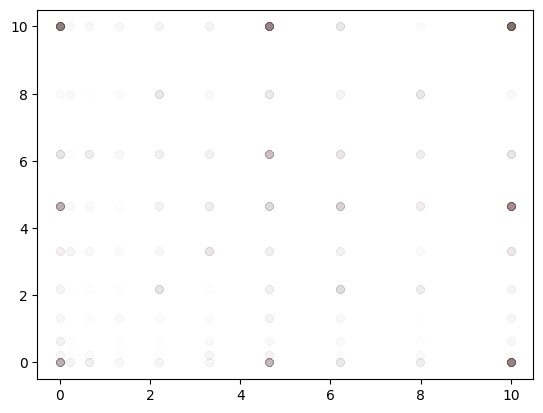

In [573]:
from tqdm.auto import tqdm
p1t=torch.tensor([0.0,0.0])
p2t=torch.tensor([0.0,0.0])
k=1
p1c=calculate_density_kernel(P1.cuda(),sigma=1.0)
#p1c=k*p1c/p1c.sum()
p2c=calculate_density_kernel(P2.cuda(),sigma=1.0)
#p2c=k*p2c/p2c.sum()
r=200
ratio=0.1
for t in tqdm(range(r)):
    p1cc = fps(P1, batch=None, ratio=ratio, random_start=True)
    p1tadd=(P1[p1cc])
    p1t=p1t+p1tadd.sum(0)
    
    p2cc = fps(P2, batch=None, ratio=ratio, random_start=True)
    p2tadd=(P2[p2cc])
    plt.scatter(*p2tadd.T,alpha=ratio*10/r)
    p2t=p2t+p2tadd.sum(0)
p1t=ratio*p1t/r
p2t=ratio*p2t/r
print("p1t:",p1t)
print("p2t:",p2t)

In [324]:
p1c.sum(),p2c.sum()

(tensor(100., device='cuda:0'), tensor(100., device='cuda:0'))

In [304]:
p1c.sum(),p2c.sum()

(tensor(100., device='cuda:0'), tensor(100., device='cuda:0'))

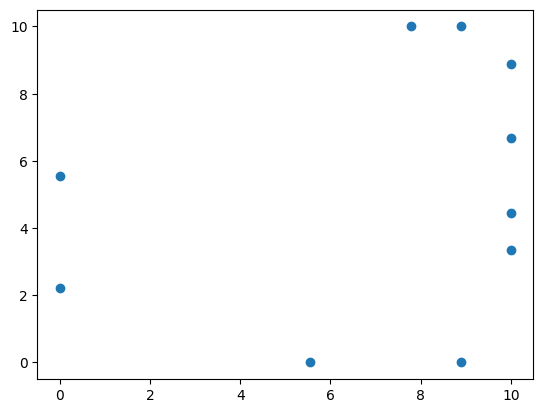

In [267]:
plt.scatter(*p1tadd.T)

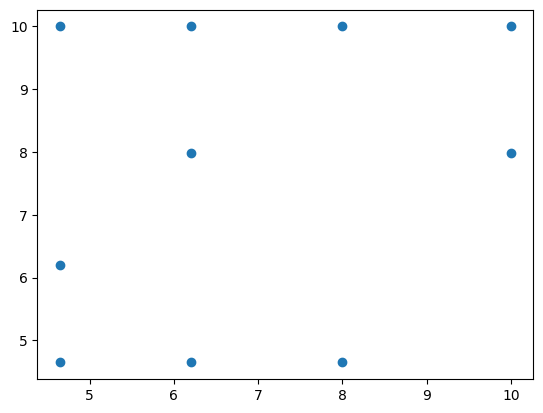

In [268]:
plt.scatter(*p2tadd.T)

In [261]:
p1c.sum(),p2c.sum()

(tensor(36.2870, device='cuda:0'), tensor(125.9977, device='cuda:0'))

In [237]:
p1c.min(),p1c.mean(),p1c.max(),p2c.min(),p2c.mean(),p2c.max(),

(tensor(0.1297, device='cuda:0'),
 tensor(0.2272, device='cuda:0'),
 tensor(0.2604, device='cuda:0'),
 tensor(0.0445, device='cuda:0'),
 tensor(0.6918, device='cuda:0'),
 tensor(2.8023, device='cuda:0'))

In [215]:
p2c

tensor([68.3560, 74.4288, 48.1563, 37.1168, 32.3406, 30.0312, 28.7184, 27.9068,
        27.3679, 26.5030, 74.4288, 81.1311, 53.4577, 40.9895, 35.9467, 33.4356,
        32.0470, 31.2023, 30.6212, 29.7185, 48.1563, 53.4577, 32.2528, 22.1175,
        17.7291, 15.4840, 14.1822, 13.3158, 12.7064, 11.8008, 37.1168, 40.9895,
        22.1175, 14.5410, 11.3116,  9.6275,  8.5725,  7.8637,  7.3521,  6.6040,
        32.3406, 35.9467, 17.7291, 11.3116,  8.2068,  6.7173,  5.8545,  5.2982,
         4.8975,  4.3335, 30.0312, 33.4356, 15.4840,  9.6275,  6.7173,  5.3193,
         4.4896,  3.9582,  3.6008,  3.0550, 28.7184, 32.0470, 14.1822,  8.5725,
         5.8545,  4.4896,  3.7319,  3.2231,  2.8836,  2.3175, 27.9068, 31.2023,
        13.3158,  7.8637,  5.2982,  3.9582,  3.2231,  2.7645,  2.4334,  1.8872,
        27.3679, 30.6212, 12.7064,  7.3521,  4.8975,  3.6008,  2.8836,  2.4334,
         2.1308,  1.5659, 26.5030, 29.7185, 11.8008,  6.6040,  4.3335,  3.0550,
         2.3175,  1.8872,  1.5659,  1.07

In [212]:
p2cc.mean()

tensor(0.0688, device='cuda:0')

In [191]:
p2tadd

tensor([[1., 1.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.],
        [1., 1.]])

In [183]:
p2tad

tensor([[10.0000, 10.0000],
        [ 7.9910, 10.0000],
        [ 4.6465, 10.0000],
        [ 7.9910,  4.6465]])

In [171]:
p2t

tensor([368., 364.])

In [164]:
P2[p2cc.topk(4,0).indices[:,0].cpu()]

tensor([[0.2132, 0.2132],
        [0.2132, 0.0000],
        [0.2132, 1.3131],
        [0.2132, 3.3109]])

In [166]:
P2.mean(0)

tensor([3.6532, 3.6532])

In [167]:
P1.mean(0)

tensor([5.0000, 5.0000])

In [122]:
pd.Series(p2c.view(-1).cpu()).sort_values()

99     1.079091
89     1.565875
98     1.565875
97     1.887157
79     1.887157
        ...    
21    53.457680
0     68.356010
1     74.428833
10    74.428833
11    81.131058
Length: 100, dtype: float32

In [25]:
X[~m.cpu(),0]

tensor([-2.9677, -2.9681, -2.9869, -2.9599, -2.9414, -2.9965, -2.9977, -2.9915,
        -3.0687, -3.0180, -3.0033, -3.0658, -3.0057, -2.5200, -2.5662, -2.6031,
        -2.5611, -2.5666, -2.4245, -2.6369, -2.5120, -2.5495, -2.4911, -2.5379,
        -2.5086, -2.4836, -2.5574, -2.0710, -2.0641, -2.0847, -2.0365, -2.0567,
        -2.0134, -2.1080, -2.1156, -2.0688, -1.9941, -1.6754, -1.5711, -1.5515,
        -1.6176, -1.5954, -1.6581, -1.6092, -1.6229, -1.6558, -1.6334, -1.5773,
        -1.6277, -1.1034, -1.1172, -1.1295, -1.1791, -1.1683, -1.1015, -1.0860,
        -1.1904, -1.2425, -1.0777, -1.2464, -0.7472, -0.7100, -0.6754, -0.6825,
        -0.6896, -0.5908, -0.7123, -0.7735, -0.6848, -0.7444, -0.7212, -0.7455,
        -0.3552, -0.2085, -0.2785, -0.2254, -0.2607, -0.2654, -0.1794, -0.2463,
        -0.2244, -0.2042, -0.2641, -0.2867, -0.2829, -0.1935,  0.3282,  0.2329,
         0.1726,  0.2067,  0.2299,  0.2727,  0.2236,  0.2590,  0.2944,  0.2765,
         0.1886,  0.2701,  0.7441,  0.72

In [23]:
m

tensor([False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
         True,  True,  True, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False,  True,
        False,  True, False, False, False, False, False, False,  True, False,
        False, False, False, False,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
         True, False,  True, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, 

In [94]:
device=torch.device('cpu')
src=torch.tensor([2,5]).to(device)
tgt=torch.tensor([3,4,6]).to(device)
edge_index = knn(src, tgt, 1, None, None).flip(0)
srcIdx, tgtIdx=edge_index
print(edge_index)
print(srcIdx)
print(tgtIdx)

tensor([[0, 1, 1],
        [0, 1, 2]])
tensor([0, 1, 1])
tensor([0, 1, 2])


In [93]:
device=torch.device('cuda:0')
src=torch.tensor([2,5]).float().to(device)
tgt=torch.tensor([3,4,6]).float().to(device)
edge_index = knn(src, tgt, 1, None, None)
srcIdx, tgtIdx=edge_index
print(edge_index)
print(srcIdx)
print(tgtIdx)

tensor([[0, 1, 2],
        [0, 1, 1]], device='cuda:0')
tensor([0, 1, 2], device='cuda:0')
tensor([0, 1, 1], device='cuda:0')


In [80]:
a[edge_index[1]]

tensor([1, 5, 5])

In [314]:
pred0

tensor([[2., 2.],
        [4., 4.],
        [4., 4.],
        [3., 3.],
        [3., 3.],
        [3., 3.],
        [3., 3.],
        [3., 3.],
        [4., 4.],
        [2., 2.],
        [4., 4.],
        [6., 6.],
        [4., 4.],
        [5., 5.],
        [5., 5.],
        [5., 5.],
        [5., 5.],
        [4., 4.],
        [7., 7.],
        [4., 4.],
        [3., 3.],
        [4., 4.],
        [4., 4.],
        [4., 4.],
        [4., 4.],
        [4., 4.],
        [4., 4.],
        [4., 4.],
        [4., 4.],
        [4., 4.],
        [3., 3.],
        [6., 6.],
        [4., 4.],
        [4., 4.],
        [4., 4.],
        [4., 4.],
        [4., 4.],
        [5., 5.],
        [5., 5.],
        [3., 3.],
        [3., 3.],
        [5., 5.],
        [4., 4.],
        [4., 4.],
        [4., 4.],
        [4., 4.],
        [5., 5.],
        [3., 3.],
        [4., 4.],
        [3., 3.],
        [3., 3.],
        [5., 5.],
        [4., 4.],
        [4., 4.],
        [3., 3.],
        [5

In [187]:
m.shape

torch.Size([100])

In [171]:
pred0.norm(2,-1).argmin()

tensor(47, device='cuda:0')

In [182]:
mask[10]

tensor(True, device='cuda:0')

In [173]:
pred0[47],Y[47],pred[47]

(tensor([0., 0.], device='cuda:0'),
 tensor([ 0.6698, -0.0121]),
 tensor([0., 0.], device='cuda:0', grad_fn=<SelectBackward0>))

In [168]:
pred0[(X-torch.tensor([-0.5,-0.5])).norm(2,-1).argmin()]

tensor([-1.0849, -1.0102], device='cuda:0')

In [174]:
edge_index=radius_graph(X, r=30, batch=None, loop=False)
diffs = X[edge_index[1]]-X[edge_index[0]]
edge_attr = model.edge_mlp(diffs)

In [79]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.pool import knn_graph

class NoModelChatGPT(MessagePassing):
    def __init__(self, k: int = 8, eps: float = 1e-8):
        super().__init__(aggr='sum')  # we manually normalize later
        self.k = k
        self.eps = eps

    def forward(self, K: torch.Tensor, V: torch.Tensor, batch: torch.Tensor = None) -> torch.Tensor:
        """
        K: [N, D]  positions
        V: [N, F]  vectors at those positions
        batch: [N]  batch indices (optional, for batched graphs)
        """
        # 1) build kNN graph on positions
        edge_index = knn_graph(K, k=self.k, batch=batch, loop=False)

        # 2) propagate V weighted by 1/dist
        weighted_sum = self.propagate(edge_index, x=V, pos=K)

        # 3) propagate weights alone to get normalization factor
        ones = torch.ones((V.size(0), 1), device=V.device)
        weight_sum = self.propagate(edge_index, x=ones, pos=K)

        # 4) normalize
        return weighted_sum / (weight_sum + self.eps)

    def message(self, x_j: torch.Tensor, pos_i: torch.Tensor, pos_j: torch.Tensor) -> torch.Tensor:
        """
        x_j: [E, F]      neighbor features
        pos_i: [E, D]    receiver positions
        pos_j: [E, D]    sender positions
        """
        # compute Euclidean distance
        dist = torch.norm(pos_i - pos_j, p=2, dim=-1, keepdim=True)  # [E,1]
        w = 1.0 / (dist + self.eps)  # [E,1]
        return w * x_j              # [E,F]


In [219]:
pred

tensor([[ 6.9741e-02,  1.5186e-01],
        [ 1.4329e-02,  2.2901e+00],
        [-1.9276e-02, -2.6135e-02],
        [ 9.0346e-02,  5.0954e-01],
        [ 3.0874e-01, -1.1861e+00],
        [ 3.6492e-01, -6.3699e-01],
        [ 4.4865e-01, -5.9038e-01],
        [ 2.4569e-01, -1.1252e-01],
        [-4.9336e-02,  4.1906e-03],
        [ 4.1815e-01, -6.6939e-01],
        [ 3.1929e-03, -2.8951e-02],
        [-3.0549e-02, -8.5008e-01],
        [-1.3559e-02, -3.6096e-01],
        [ 2.6854e-02,  3.3071e-02],
        [-1.9948e-01,  1.7099e-01],
        [ 1.2373e-01, -9.0453e-01],
        [ 6.0018e-02,  2.3112e-02],
        [ 2.9457e-01, -1.7330e+00],
        [ 2.0988e-03, -1.1039e+00],
        [ 1.0393e-02,  1.2917e-01]], grad_fn=<ScatterAddBackward0>)

In [220]:
Y

tensor([[-1.0040,  0.5947],
        [-1.1241,  1.8918],
        [ 0.1411,  0.9897],
        [-1.0379,  1.1058],
        [ 0.5125, -1.9463],
        [ 0.3850, -1.3131],
        [ 0.6965, -1.6173],
        [-0.0213,  0.1385],
        [ 1.2331,  0.6428],
        [ 0.5902, -1.0446],
        [ 0.0968,  0.7927],
        [-0.6171, -1.0588],
        [-0.7765, -0.3919],
        [ 1.4637,  0.3470],
        [ 0.2192,  1.3419],
        [-0.3532, -0.4946],
        [ 1.0141,  0.3009],
        [ 0.5657, -3.1162],
        [-0.2598, -1.7869],
        [ 1.2677,  0.3885]])

In [103]:
model=Predictor()
optimizer=torch.optim.AdamW(model.parameters())
scale,phi_out=model(X[0]+0.000001,X,Y)

In [105]:
scale.shape,phi_out.shape,scale[...,0]@phi_out#,(scale.broadcast_to(-1,2)*phi_out).sum(-2)#(scale[...,0]).shape

(torch.Size([100, 1]),
 torch.Size([100, 2]),
 tensor([-0.9203, -0.1643], grad_fn=<SqueezeBackward4>))

In [102]:
phi_out

tensor([[-4.5015e-01,  2.3072e-01],
        [-1.1692e-01,  8.6830e-03],
        [-3.7591e-02,  3.9875e-02],
        [-1.5103e-01, -2.3743e-01],
        [ 9.9905e-02,  1.4528e-01],
        [-1.9542e-01,  3.8494e-02],
        [ 2.7479e-01,  1.2498e-01],
        [ 2.4534e-01,  5.5533e-02],
        [-7.0250e-02, -3.7781e-02],
        [ 3.6719e-01, -4.8245e-02],
        [-1.3726e-01,  4.8469e-02],
        [-1.2181e-02, -8.0723e-02],
        [ 1.3180e-01, -5.3776e-02],
        [ 7.1632e-02, -1.5625e-01],
        [-2.3066e-01, -5.7674e-02],
        [ 8.0676e-02, -1.7213e-01],
        [-6.9150e-02,  8.0397e-02],
        [ 1.2792e-01,  2.8756e-02],
        [-1.7344e-01,  1.6534e-02],
        [ 3.4234e-02, -6.4918e-02],
        [-5.1526e-01, -1.8989e-02],
        [-6.9316e-02,  1.5262e-01],
        [-1.6985e-01,  1.6357e-01],
        [-1.7361e-01,  5.5545e-02],
        [-3.5566e-02,  7.9135e-02],
        [-1.1549e-01, -1.2044e-01],
        [-7.5778e-02, -9.4821e-02],
        [-3.1618e-01, -1.367

In [31]:
p=torch.tensor([0.0001,2,2,4,3]).float()
(p.pow(-2)/p.pow(-2).sum())

tensor([1.0000e+00, 2.5000e-09, 2.5000e-09, 6.2500e-10, 1.1111e-09])

In [5]:
Y[:3]

tensor([[-0.2765, -0.3860],
        [-0.2000,  0.1820],
        [-1.4991, -0.7617]])

In [ ]:
from typing import Optional

import torch
from torch import Tensor
from torch.nn import Parameter

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import zeros
from torch_geometric.typing import (
    Adj,
    OptPairTensor,
    OptTensor,
    SparseTensor,
    torch_sparse,
)
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils import add_self_loops as add_self_loops_fn
from torch_geometric.utils import (
    is_torch_sparse_tensor,
    scatter,
    spmm,
    to_edge_index,
)
from torch_geometric.utils.num_nodes import maybe_num_nodes
from torch_geometric.utils.sparse import set_sparse_value
class Interpolator(MessagePassing):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        improved: bool = False,
        cached: bool = False,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)

        if add_self_loops is None:
            add_self_loops = normalize

        if add_self_loops and not normalize:
            raise ValueError(f"'{self.__class__.__name__}' does not support "
                             f"adding self-loops to the graph when no "
                             f"on-the-fly normalization is applied")

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.add_self_loops = add_self_loops
        self.normalize = normalize

        self.lin = Linear(in_channels, out_channels, bias=False,
                          weight_initializer='glorot')


        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin.reset_parameters()
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:

        x = self.lin(x)

        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight)

        return out


    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: Adj, x: Tensor) -> Tensor:
        return spmm(adj_t, x, reduce=self.aggr)